In [1]:
#Librerias básicas
#================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from pandas.core.frame import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import multiprocessing

import cv2

# Activar SQL en Python
# ================================================================================
con = duckdb.connect(database=':memory:')

In [2]:
#Url Ari 
url_lcc    = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet-detection-with-Neural-Network/Curvas_de_luz_cor/"
url_lc_img = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Curvas_de_luz_img/"
url_img = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/"
url        = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet-detection-with-Neural-Network/"

In [3]:
#Urls Pater
url_lcc    = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet-detection-with-Neural-Network/Curvas_de_luz_cor/"
url_lc_img = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/ClassificationExoplanets/Curvas_de_luz_img/"
url_img = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/ClassificationExoplanets/"
url        = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet-detection-with-Neural-Network/"

## Creación de las imagenes

In [3]:
Carac_Stars = pd.read_csv(url+"Carac_Stars.csv")
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [4]:
arch = os.listdir(url_lcc) 
arch.sort()
Stars_list = [star[3:-4] for star in arch]

s_flux  = []
s_err   = []
Id_real = []
for Str in arch:
    serie = pd.read_csv(url_lcc+Str).set_index('time')
    s_flux.append(np.array(serie['flux']))
    s_err.append(np.array(serie['flux_err']))
    Id_real.append(Str[3:-4])


In [5]:
Stars = pd.DataFrame()
Stars["ID"] = Id_real
Stars

,ID
0,10000162
1,10000941
2,10001368
3,10002049
4,10002266
...,...
7677,9993683
7678,9994381
7679,9995402
7680,9995771


In [6]:
Clas_Stars = con.execute("""select S.ID, case when C.Clasificacion == 'CANDIDATE' then 1 
                                              else 0             
                                         end as ClasBin
                            from Carac_Stars C inner join Stars S on (S.ID = C.Kepler_ID)
                            order by S.ID""").df()
Clas_Stars

,ID,ClasBin
0,10000162,1
1,10000941,1
2,10001368,1
3,10002049,1
4,10002266,0
...,...,...
7677,9993683,1
7678,9994381,1
7679,9995402,1
7680,9995771,1


In [7]:
#Obtención de las imagenes ya existentes en la carpeta
contenido = os.listdir(url_lc_img)
L_Str = []
for Str in contenido:
    Str = Str[4:-4]
    L_Str.append(Str)

In [8]:
#Se descargan las curvas de luz no existentes
KEPID = list(Stars['ID'])
i = 0
for name in KEPID:
    if name in L_Str:
        i += 1
        continue
    else:
        j = KEPID.index(name)
        name = int(name)
        plt.figure(figsize=(8,4))
        plt.plot(s_flux[j],color="#000000")
        plt.axis('off')
        plt.savefig(f"{url_lc_img}Img_{name}", dpi=72, bbox_inches='tight')
        plt.close()
        continue

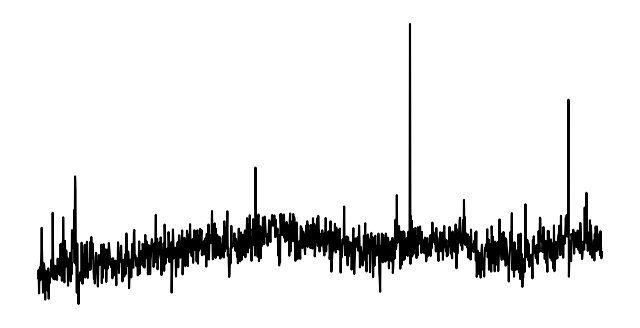

In [9]:
j = 300
name = "Prueba"
plt.figure(figsize=(8,4))
plt.plot(s_flux[j],color="#000000")
plt.axis('off')
plt.savefig(f"{url_lc_img}Img_{name}", dpi=72, bbox_inches='tight')

## División conjuntos train, validation, test

In [7]:
contenido = os.listdir(url_lc_img)
Img_LC = []
i = 0
for img in contenido:
    i += 1
    #Se obtienen las imagenes normalizadas en escala de grises
    Img = cv2.imread(url_lc_img+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    Img_LC.append(Img)

In [8]:
# ordenar las imágenes y sus respectivos labels
list_img = os.listdir(url_lc_img)
for i in range(len(list_img)):
    Str = list_img[i][4:-4]
    list_img[i] = Str

# obtención de labels correspondientes a cada imagen
Clas_Stars['ID'] = pd.Categorical(Clas_Stars['ID'], categories=list_img, ordered=True)
Labels = np.array(Clas_Stars.sort_values('ID')['ClasBin'])

In [9]:
# División entrenamiento, validación y prueba
Img_train, Img_test, Labs_train, Labs_test = train_test_split(
    Img_LC, Labels, test_size=0.3, random_state=13)

Img_val, Img_test, Labs_val, Labs_test = train_test_split(
    Img_test, Labs_test, test_size=0.33333333333333333, random_state=13)

In [10]:
print("Estrellas con exoplanetas en train: ",len(Labs_train[Labs_train==1]))
print("Estrellas sin exoplanetas en train: ",len(Labs_train[Labs_train==0]))
print("Estrellas con exoplanetas en val: ",len(Labs_val[Labs_val==1]))
print("Estrellas sin exoplanetas en val: ",len(Labs_val[Labs_val==0]))
print("Estrellas con exoplanetas en test: ",len(Labs_test[Labs_test==1]))
print("Estrellas sin exoplanetas en test: ",len(Labs_test[Labs_test==0]))

Estrellas con exoplanetas en train:  2274
Estrellas sin exoplanetas en train:  3103
Estrellas con exoplanetas en val:  649
Estrellas sin exoplanetas en val:  887
Estrellas con exoplanetas en test:  323
Estrellas sin exoplanetas en test:  446


In [36]:
for i in range(len(Img_train)):
    if Labs_train[i]==1:
        plt.figure(figsize=(8,4))
        plt.imshow(Img_train[i])
        plt.axis('off')
        plt.savefig(f"{url_img}Train_img/1/{i}", dpi=72, bbox_inches='tight')
        plt.close()
    elif Labs_train[i]==0:
        plt.figure(figsize=(8,4))
        plt.imshow(Img_train[i])
        plt.axis('off')
        plt.savefig(f"{url_img}Train_img/0/{i}", dpi=72, bbox_inches='tight')
        plt.close()
    else:
        continue

In [37]:
for i in range(len(Img_val)):
    if Labs_val[i]==1:
        plt.figure(figsize=(8,4))
        plt.imshow(Img_val[i])
        plt.axis('off')
        plt.savefig(f"{url_img}Val_img/1/{i}", dpi=72, bbox_inches='tight')
        plt.close()
    elif Labs_val[i]==0:
        plt.figure(figsize=(8,4))
        plt.imshow(Img_val[i])
        plt.axis('off')
        plt.savefig(f"{url_img}Val_img/0/{i}", dpi=72, bbox_inches='tight')
        plt.close()
    else:
        continue

In [38]:
for i in range(len(Img_test)):
    if Labs_test[i]==1:
        plt.figure(figsize=(8,4))
        plt.imshow(Img_test[i])
        plt.axis('off')
        plt.savefig(f"{url_img}Test_img/1/{i}", dpi=72, bbox_inches='tight')
        plt.close()
    elif Labs_test[i]==0:
        plt.figure(figsize=(8,4))
        plt.imshow(Img_test[i])
        plt.axis('off')
        plt.savefig(f"{url_img}Test_img/0/{i}", dpi=72, bbox_inches='tight')
        plt.close()
    else:
        continue

## Modelo de redes convolucionales

In [47]:
Train_img = []
y_train = []
Arch_Train_1 = os.listdir(url_img+"Train_img/1/")
Arch_Train_0 = os.listdir(url_img+"Train_img/0/")

for img in Arch_Train_1:
    Img = cv2.imread(url_img+"Train_img/1/"+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    y_train.append(1)
    Train_img.append(Img)
    
for img in Arch_Train_0:
    Img = cv2.imread(url_img+"Train_img/0/"+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    y_train.append(0)
    Train_img.append(Img)
    
Val_img = []
y_val = []
Arch_Val_1 = os.listdir(url_img+"Val_img/1/")
Arch_Val_0 = os.listdir(url_img+"Val_img/0/")

for img in Arch_Val_1:
    Img = cv2.imread(url_img+"Val_img/1/"+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    y_val.append(1)
    Val_img.append(Img)
    
for img in Arch_Val_0:
    Img = cv2.imread(url_img+"Val_img/0/"+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    y_val.append(0)
    Val_img.append(Img)
    
Test_img = []
y_test = []
Arch_Test_1 = os.listdir(url_img+"Test_img/1/")
Arch_Test_0 = os.listdir(url_img+"Test_img/0/")

for img in Arch_Test_1:
    Img = cv2.imread(url_img+"Test_img/1/"+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    y_test.append(1)
    Test_img.append(Img)
    
for img in Arch_Test_0:
    Img = cv2.imread(url_img+"Test_img/0/"+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    y_test.append(0)
    Test_img.append(Img)

In [48]:
Matriz_1 = np.ones((236,446))

Train_img = Matriz_1 - np.array(Train_img)
Val_img = Matriz_1 - np.array(Val_img)
Test_img = Matriz_1 - np.array(Test_img)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [49]:
Train_img = Train_img.reshape((len(Train_img),236,446,1))
Val_img = Val_img.reshape((len(Val_img),236,446,1))
Test_img = Test_img.reshape((len(Test_img),236,446,1))

In [ ]:
Train_imgc =Train_img.copy()

In [54]:
Train_imgc = np.concatenate((Train_imgc, Train_imgc),axis = 3).astype(np.float32)

MemoryError: Unable to allocate 8.43 GiB for an array with shape (5377, 236, 446, 2) and data type float64

In [52]:
Train_imgc.shape

(5377, 236, 446, 1)

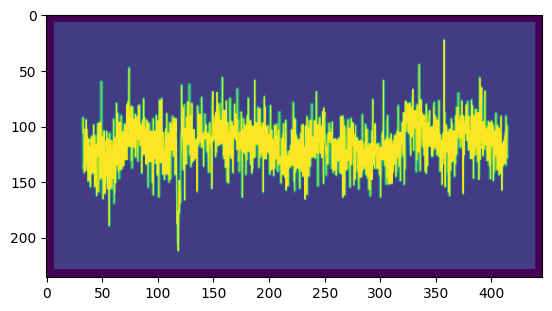

In [43]:
plt.imshow(Train_img[1])
plt.show()

In [59]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=1,padding="same", input_shape=(236,446,1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',strides=1,padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [60]:
#CallBack para detener entrenamiento
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.985):
            print("\nSe alcanzó un 98.5% de precisión en la validación! Cancelando Entrenamiento...")
            self.model.stop_training = True
        elif(logs.get('accuracy')>0.9):
            print("\nSe alcanzó un 90.0% de precisión en el entrenaminto! Cancelando Entrenamiento...")
            self.model.stop_training = True

# crea una instancia de clase
accu_callback = MNIST_Callback()

In [61]:
#Compilador del modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 236, 446, 64)      640       
                                                                 
 conv2d_26 (Conv2D)          (None, 236, 446, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 118, 223, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 116, 221, 128)     73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 114, 219, 128)     147584    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 57, 109, 128)      0         
 ng2D)                                                

In [63]:
history = model.fit(Train_img, y_train, 
                    epochs=20, 
                    validation_data = (Val_img,y_val),
                    batch_size=16,
                    callbacks=[accu_callback])

Epoch 1/20
169/337 [==============>...............] - ETA: 1:06:04 - loss: 0.6816 - accuracy: 0.5869

KeyboardInterrupt: 

In [ ]:
model.save(url+'Conv.h5')